# CREMA-D Audio Preprocessing Pipeline
This notebook preprocesses the CREMA-D audio dataset (https://www.kaggle.com/datasets/ejlok1/cremad) stored in Google Drive. It creates stratified train/test/val splits, generates log-mel spectrograms, extracts embeddings using ResNet18, VGG16, and PANNs (Cnn14), and computes MFCC features as 2D arrays.

Before running, ensure your Google Drive is mounted and `DATA_ROOT` points to the folder containing the `AudioWAV` directory.


In [4]:
# Mount Google Drive (only in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    # Not running in Colab
    pass

repo_path = '/content/qnn-transfer-learning'
import os
if not os.path.isdir(repo_path):
  %cd /content
  !git clone https://github.com/lburdman/qnn-transfer-learning.git
%cd qnn-transfer-learning

import sys
sys.path.append('src')

!pip install panns-inference

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
Cloning into 'qnn-transfer-learning'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 129 (delta 57), reused 101 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (129/129), 6.27 MiB | 30.45 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/qnn-transfer-learning


In [5]:
import os
import glob
import random
from pathlib import Path

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import models, transforms
from tqdm.notebook import tqdm
from panns_inference import AudioTagging
import warnings
warnings.filterwarnings('ignore')

# Set the root directory on your Google Drive
DATA_ROOT = '/content/drive/MyDrive/CREMAD'  # modify if needed
AUDIO_DIR = os.path.join(DATA_ROOT, 'AudioWAV')
SPLITS_DIR = os.path.join(DATA_ROOT, 'splits')
SPEC_DIR = os.path.join(DATA_ROOT, 'Spectrograms')
EMB_DIR = os.path.join(DATA_ROOT, 'Embeddings')
MFCC_DIR = os.path.join(DATA_ROOT, 'MFCCs')
PANN_DIR = os.path.join(EMB_DIR, 'PANNs_Cnn14')

# Create base directories if they do not exist
os.makedirs(SPLITS_DIR, exist_ok=True)
os.makedirs(SPEC_DIR, exist_ok=True)
os.makedirs(EMB_DIR, exist_ok=True)
os.makedirs(MFCC_DIR, exist_ok=True)

# Emotion classes in CREMA-D
CLASSES = ['HAP', 'SAD', 'ANG', 'NEU', 'DIS', 'FEA']

# Audio parameters
TARGET_SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
N_MFCC = 40

# Determine the device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

from src.utils import create_dir, load_image
from src.wav_to_spec import (save_melspectrogram, process_spectrograms, build_embedding_transform,
                              extract_embeddings, process_panns_embeddings, process_mfccs, extract_panns_embedding)
from src.visualize_melspec import show_example_spectrograms, show_example_mfcc


Using device: cuda


In [6]:
# Initialize PANNs AudioTagging model
audio_tagging = AudioTagging(checkpoint_path=None, device=device)


Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


In [7]:
# Create stratified train/test/validation splits
file_paths = glob.glob(os.path.join(AUDIO_DIR, '*.wav'))
records = []

for fp in file_paths:
    fname = os.path.basename(fp)
    # Identify the class label by searching for known class substrings in the file name
    label_found = None
    for cls in CLASSES:
        if cls in fname:
            label_found = cls
            break
    # Append record if a valid class is found
    if label_found is not None:
        records.append({
            'file_path': fp,
            'file_name': fname,
            'label': label_found
        })

# Create DataFrame
df = pd.DataFrame(records)

# Check that the dataframe is not empty
if df.empty:
    raise ValueError('No audio files found. Please check the AUDIO_DIR path.')

# Perform stratified split: 70% train, 20% test, 10% validation
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.125, stratify=train_val_df['label'], random_state=42)  # 0.125 of 80% = 10%

# Save splits to CSV files
train_df.to_csv(os.path.join(SPLITS_DIR, 'train.csv'), index=False)
test_df.to_csv(os.path.join(SPLITS_DIR, 'test.csv'), index=False)
val_df.to_csv(os.path.join(SPLITS_DIR, 'val.csv'), index=False)

print(f'Train size: {len(train_df)}, Test size: {len(test_df)}, Val size: {len(val_df)}')

Train size: 5208, Test size: 1489, Val size: 744


In [17]:
# Show count of files per class and split
split_counts = {
    'train': train_df['label'].value_counts(),
    'test': test_df['label'].value_counts(),
    'val':  val_df['label'].value_counts()
}

stats_df = pd.DataFrame(split_counts).reindex(CLASSES).fillna(0).astype(int)

print('\nNúmero de audios por clase y split:')
print(stats_df)
print('\nTotal de audios por split:')
print('Train:', len(train_df))
print('Test :', len(test_df))
print('Val  :', len(val_df))

# Save splits to CSV files
train_df.to_csv(os.path.join(SPLITS_DIR, 'train.csv'), index=False)
test_df.to_csv(os.path.join(SPLITS_DIR, 'test.csv'), index=False)
val_df.to_csv(os.path.join(SPLITS_DIR, 'val.csv'), index=False)



Número de audios por clase y split:
       train  test  val
label                  
HAP      890   254  127
SAD      889   254  127
ANG      890   254  127
NEU      760   218  109
DIS      890   254  127
FEA      889   255  127

Total de audios por split:
Train: 5208
Test : 1489
Val  : 744


In [8]:
# Helper setup
embedding_transform = build_embedding_transform()

In [10]:
# Generate mel spectrograms
# process_spectrograms(train_df, 'train', SPEC_DIR, TARGET_SR, N_FFT, HOP_LENGTH, N_MELS)
# process_spectrograms(test_df, 'test', SPEC_DIR, TARGET_SR, N_FFT, HOP_LENGTH, N_MELS)
process_spectrograms(val_df, 'val', SPEC_DIR, TARGET_SR, N_FFT, HOP_LENGTH, N_MELS)

Generating spectrograms for val: 100%|██████████| 744/744 [02:55<00:00,  4.24it/s]


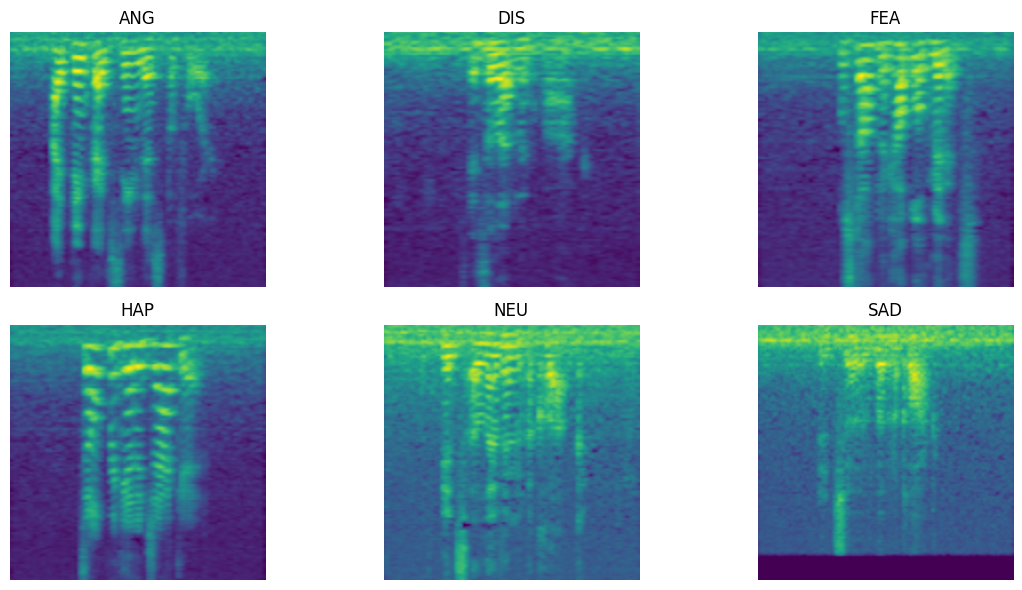

In [11]:
# Visualize example mel spectrograms
val_specs_root = os.path.join(SPEC_DIR, 'val')
if os.path.exists(val_specs_root):
    show_example_spectrograms(val_specs_root, n_classes=len(CLASSES))
else:
    print(f'No spectrograms found at {val_specs_root}')


In [12]:
# Generate embeddings using pretrained models
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.fc = torch.nn.Identity()
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16.classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-1])
# for split_name in ['train', 'test', 'val']:
for split_name in ['val']:
  extract_embeddings(resnet18, 'ResNet18', split_name, CLASSES, SPEC_DIR, EMB_DIR, device, embedding_transform)
  extract_embeddings(vgg16, 'VGG16', split_name, CLASSES, SPEC_DIR, EMB_DIR, device, embedding_transform)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 74.6MB/s]


In [13]:
# Generate PANNs (Cnn14) embeddings
for split_name, split_df in [('val', val_df)]:
  process_panns_embeddings(split_df, split_name, PANN_DIR, CLASSES, audio_tagging)

PANNs embeddings for val: 100%|██████████| 744/744 [03:49<00:00,  3.25it/s]


In [14]:
# Generate MFCCs
# process_mfccs(train_df, 'train', MFCC_DIR, TARGET_SR, N_MFCC, N_FFT, HOP_LENGTH)
# process_mfccs(test_df, 'test', MFCC_DIR, TARGET_SR, N_MFCC, N_FFT, HOP_LENGTH)
process_mfccs(val_df, 'val', MFCC_DIR, TARGET_SR, N_MFCC, N_FFT, HOP_LENGTH)

Generating MFCCs for val: 100%|██████████| 744/744 [00:25<00:00, 29.29it/s]


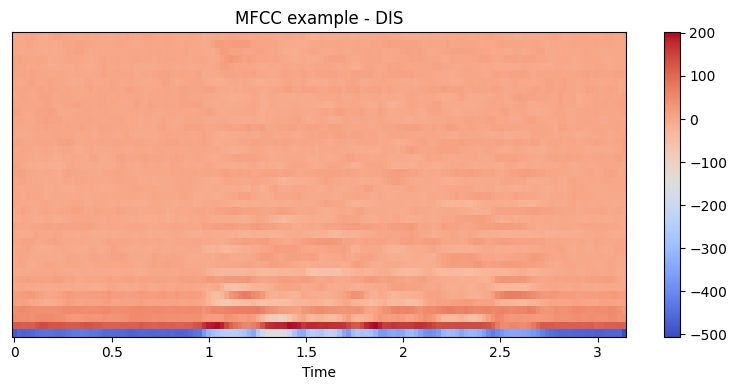

In [16]:
# Visualize example MFCC
if not train_df.empty:
    example_path = train_df.iloc[0]['file_path']
    example_label = train_df.iloc[0]['label']
    y, sr = librosa.load(example_path, sr=TARGET_SR)
    mfcc_example = librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )
    show_example_mfcc(mfcc_example, title=f'MFCC example - {example_label}')
else:
    print('No training samples available for MFCC visualization.')


## Processing complete
Your data has been split into train, test and validation sets, log-mel spectrograms generated, embeddings extracted using ResNet18, VGG16, and PANNs Cnn14, and MFCC features (2D arrays) computed.

Adjust the `DATA_ROOT` variable at the top if your data is stored elsewhere.
